In [ ]:
# taken from: https://github.com/Galaxeee/TedSim/blob/main/vignettes/Simulate-data-multi.Rmd

In [219]:
library(devtools)
library(TedSim)
library(dplyr)
library(Seurat)
library(ggplot2)
library(reshape2)
library(ctc)
library(ape)
#
library(dichromat)
library(scales)

In [220]:
ncells <- 1024
phyla <- read.tree(text='((t1:3, (t2:2, t3:2):1):1);')
#phyla <- read.tree(text='((t1:2, t2:2):1, (t3:2, t4:2):1):2;')
N_nodes <- 2*ncells-2
ngenes <- 500
max_walk <- 6
p_a <- 0.6
n_cif <- 30
n_diff <- 20
cif_step <- 0.25
p_d <- 0
mu <- 0.1
N_char <- 32
unif_on <- FALSE
set.seed(233)

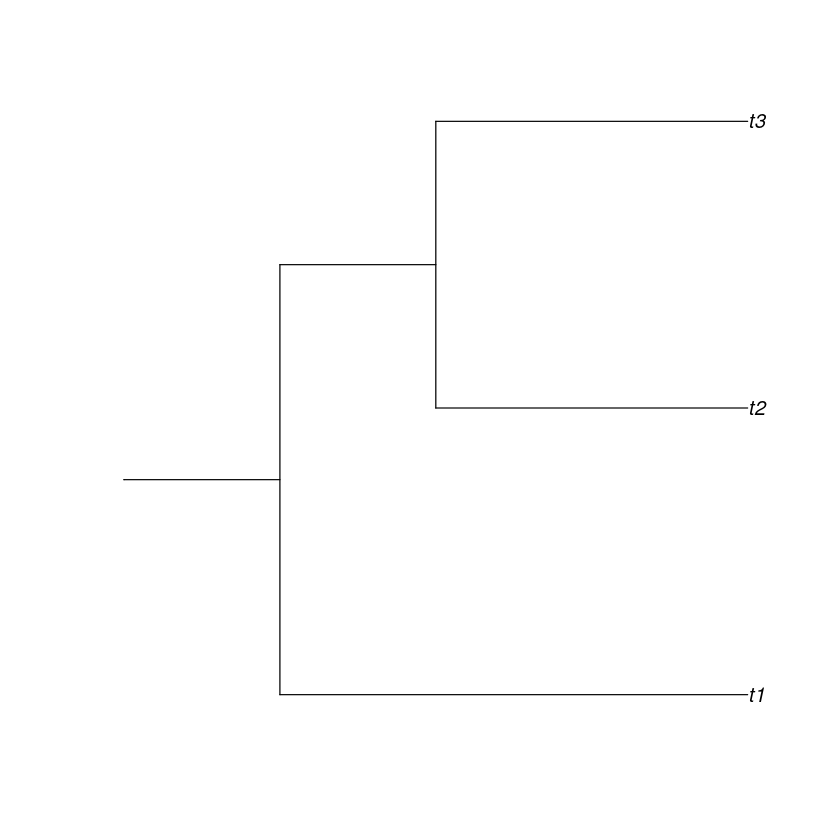

In [221]:
plot(phyla)

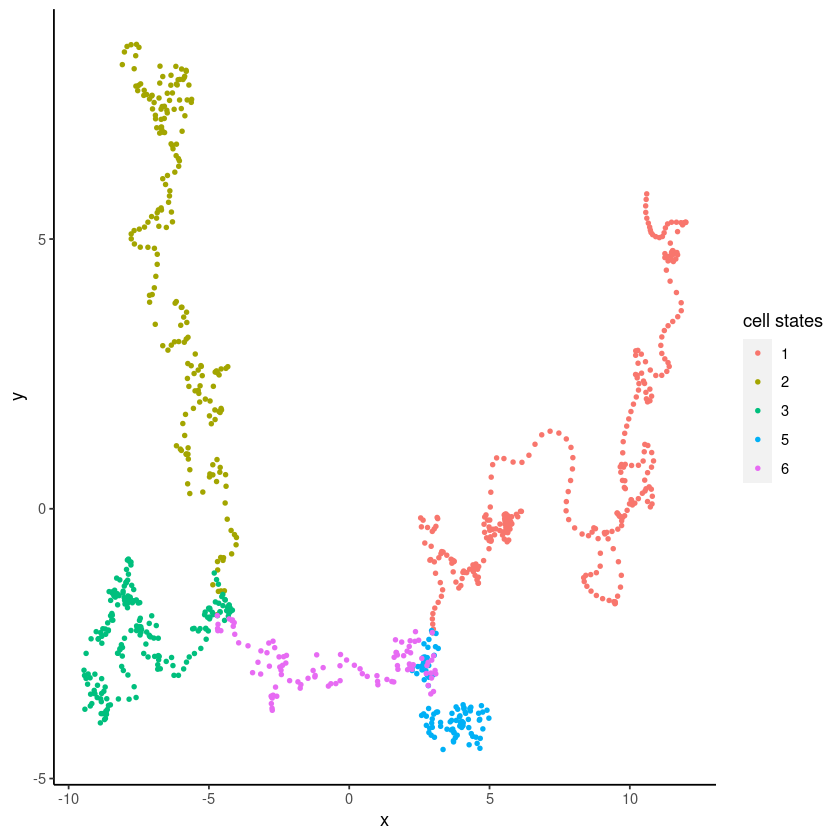

In [222]:
returnlist <- SIFGenerate(phyla, n_diff, step = cif_step)
sif_mean_raw <- returnlist$sif_mean_raw
sif_label <- sif_mean_raw[[1]][,2]
sif_mean_raw <- lapply(sif_mean_raw,function(X){
  X[,4]
})
sif_mean_raw <- do.call(cbind,sif_mean_raw)
sif_pca <- prcomp(sif_mean_raw)
plot_pca <- data.frame(label=sif_label,x=sif_pca$x[,1],y=sif_pca$x[,2])
p <- ggplot(plot_pca, aes(x, y))
p <- p + geom_point(aes(colour = factor(label)),shape=20) + labs(color='cell states')
p <- p+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
             panel.background = element_blank(), axis.line = element_line(colour = "black"))
p

In [223]:
cifs <- SimulateCIFs(ncells,phyla,p_a = p_a,n_CIF = n_cif,n_diff = n_diff,
                     step = cif_step, p_d = p_d, mu = mu,
                     Sigma = 0.5, N_char = N_char,
                     max_walk = max_walk, SIF_res = returnlist, unif_on = unif_on)
#We only need the leaf cells for experiments
cif_leaves <- lapply(c(1:3),function(parami){
  cif_leaves_all <- cifs[[1]][[parami]][c(1:ncells),]
  return(cif_leaves_all)
})
cif_res <- list(cif_leaves,cifs[[2]])
states <- cifs[[2]]
states <- states[1:N_nodes,]
states_leaves <- states[1:ncells,]
muts <- cifs[[7]]
rownames(muts) <- paste("cell",states[,4],sep = "_")
muts_leaves <- muts[1:ncells,]
#simulate true counts
true_counts_res <- CIF2Truecounts(ngenes = ngenes, ncif = n_cif,
                                  ge_prob = 0.3,ncells = ncells, cif_res = cif_res)

Warning message in cbind(...):
“number of rows of result is not a multiple of vector length (arg 3)”


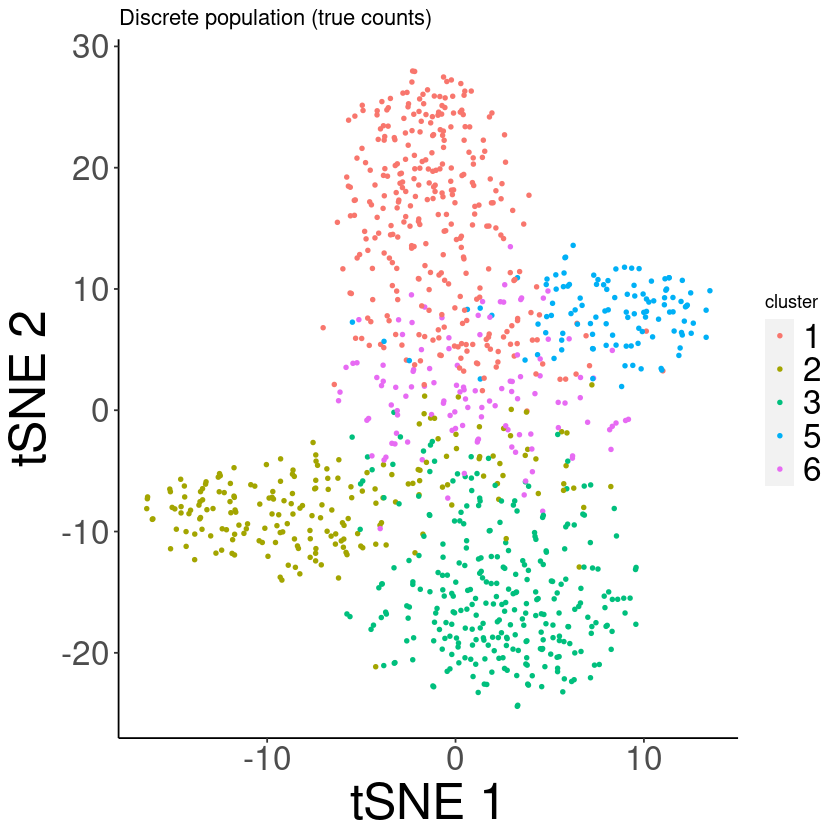

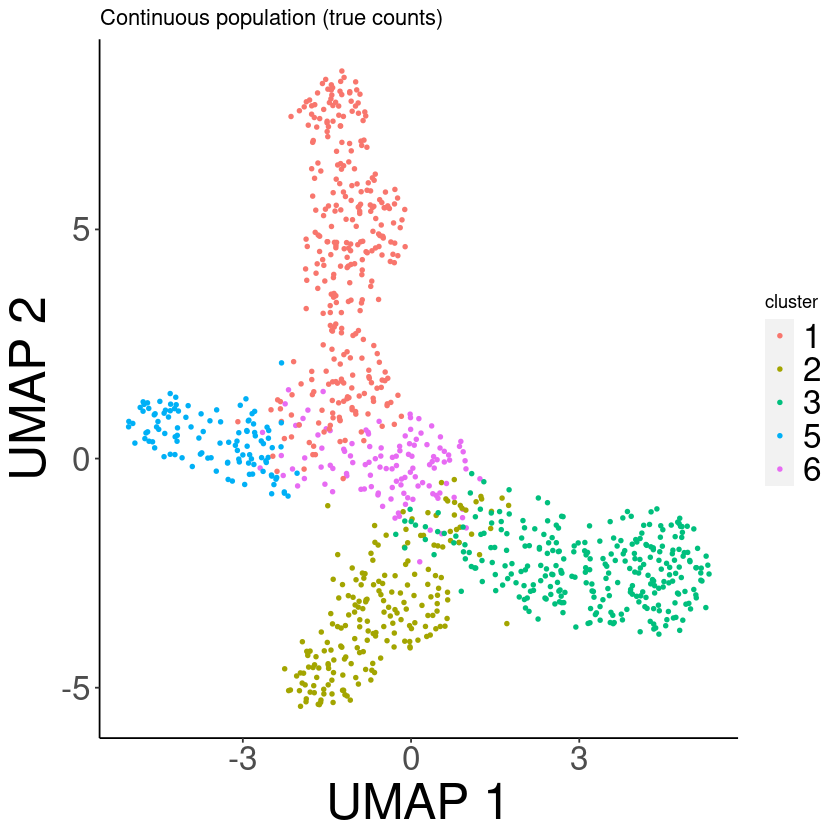

In [225]:
tsne_true_counts <- PlotTsne(meta=states_leaves, data=log2(true_counts_res[[1]]+1), cif_type="continuous", n_pc=30, label='cluster', saving = F, plotname="Discrete population (true counts)")
umap_true_counts <- PlotUmap(meta=states_leaves, data=log2(true_counts_res[[1]]+1), n_pc=30, label='cluster', saving = F, plotname="Differentiating population (true counts)")
tsne_true_counts[[2]] + ggtitle("Discrete population (true counts)") + xlab("tSNE 1") + ylab("tSNE 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))
umap_true_counts[[2]] + ggtitle("Continuous population (true counts)") + xlab("UMAP 1") + ylab("UMAP 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))

[1] "#BFD7FF" "#A0C3FF" "#80AFFF" "#619CFF"
 [1] "#FEEBEA" "#FDE1DF" "#FDD7D5" "#FCCECA" "#FCC4C0" "#FBBAB6" "#FBB0AB"
 [8] "#FAA6A1" "#FA9D96" "#F9938C" "#F98981" "#F87F77" "#F8766D"
[1] "#FBC1F3" "#F9A2EE" "#F783E8" "#F564E3"
[1] "#CCF1D7" "#B2EAC3" "#99E3AF" "#7FDC9B" "#65D587" "#4CCE73" "#32C75F"
[8] "#19C04B" "#00BA38"
[1] "#F0EBCC" "#E9E2B2" "#E2D899" "#DBCF7F" "#D3C565" "#CCBB4C" "#C5B232"
[8] "#BEA819" "#B79F00"


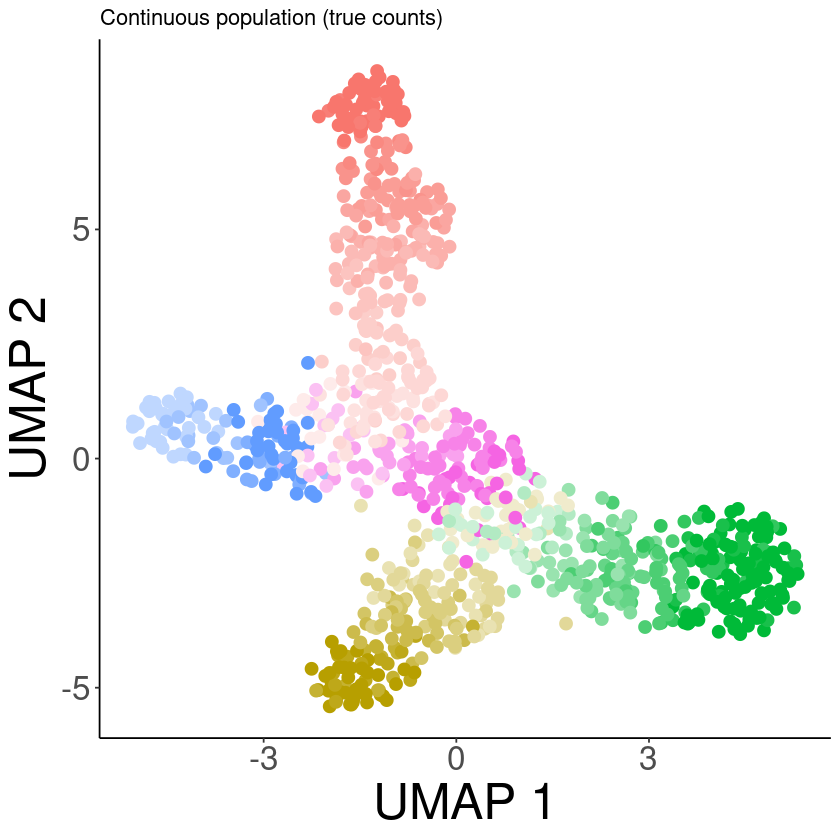

In [226]:
colors <- hue_pal()(6)
color <- states_leaves[,'cluster']
for (cluster in unique(states_leaves[,'cluster'])){
  depth_range <- sort(unique(states_leaves[states_leaves[,'cluster']==cluster,'depth']))
  edge <- phyla$edge[phyla$edge[,2] == cluster]
  #colfunc<-colorRampPalette(c(colors[edge[1]],colors[edge[2]]))
  colfunc<-colorRampPalette(c('#FFFFFF',colors[edge[2]]))
  color_grad <- colfunc(length(depth_range)+2)
  color_grad <- color_grad[0:-2]
  
  #plot(rep(1,length(depth_range)),col=color_grad,pch=19,cex=3)
  print(color_grad)
  
  color_sub <- states_leaves[states_leaves[,'cluster']==cluster,'depth']
  color_sub[color_sub %in% depth_range] <- color_grad[match(color_sub, depth_range, nomatch = 0)]
  color[color == cluster] <- color_sub
}
states_leaves <- cbind(states_leaves,color)
# create a character vector of colornames
colr <- as.character(unique(states_leaves[,'color']))
plot_umap <- umap_true_counts[[1]] 
p <- ggplot(plot_umap, aes(x, y))
p <- p + geom_point(aes(colour = as.factor(states_leaves[,'color'])),shape=20,size = 5) + labs(color='cell state')
p <- p+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))
p <- p + scale_color_manual(breaks=unique(states_leaves[,'color']), values=colr)
p + theme(legend.position = "none") + ggtitle("Continuous population (true counts)") + xlab("UMAP 1") + ylab("UMAP 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))

In [227]:
data(gene_len_pool)
gene_len <- sample(gene_len_pool, ngenes, replace = FALSE)
observed_counts <- True2ObservedCounts(true_counts=true_counts_res[[1]], meta_cell=true_counts_res[[3]],
                                       protocol="UMI", alpha_mean=0.2,
                                       alpha_sd=0.05, gene_len=gene_len, depth_mean=1e5, depth_sd=3e3)

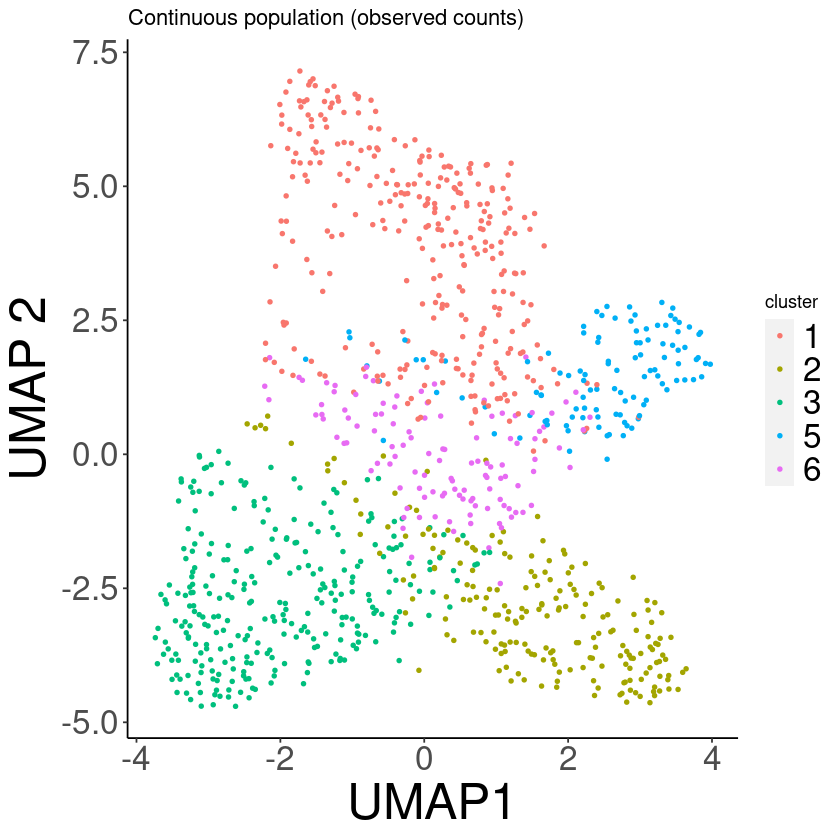

In [228]:
umap_UMI_counts <- PlotUmap(meta=states_leaves, data=log2(observed_counts[[1]]+1), n_pc=30, label='cluster', saving = F, plotname="Differentiating population (observed counts)")
umap_UMI_counts[[2]] + ggtitle("Continuous population (observed counts)") + xlab("UMAP1") + ylab("UMAP 2") +  theme(axis.text = element_text(size = 20), axis.title = element_text(size = 30),legend.text = element_text(size = 20))

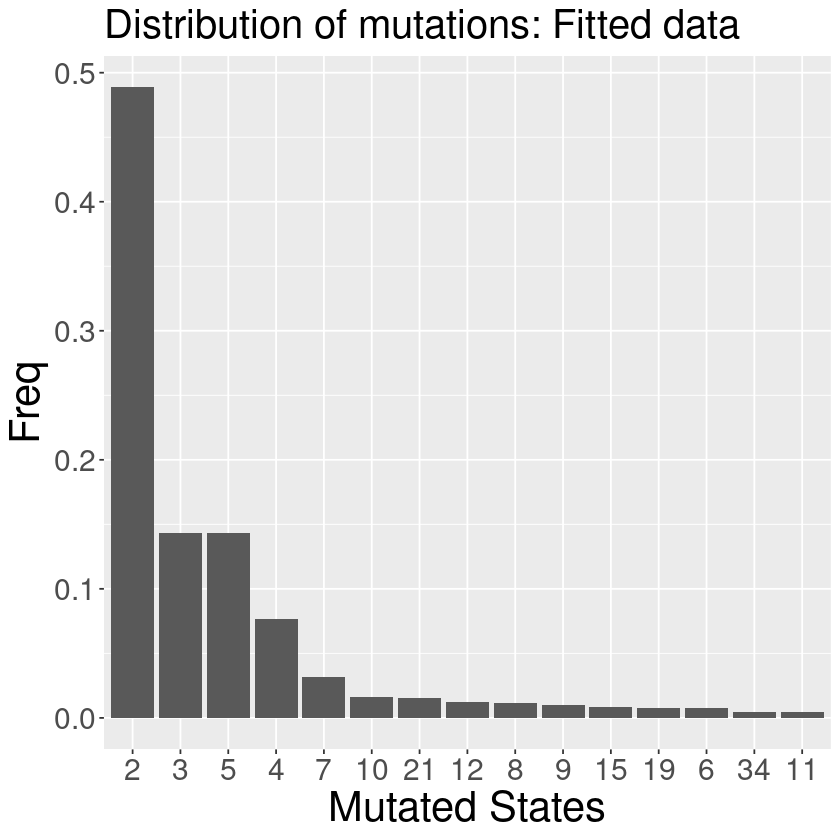

In [229]:
muts_table <- table(unlist(muts))
muts_table <- muts_table[dimnames(muts_table)[[1]]!='0']
muts_table <- muts_table[dimnames(muts_table)[[1]]!='-']
muts_prop <- prop.table(sort(muts_table,decreasing = TRUE))
muts_prop <- muts_prop[1:15]
df_prop <- as.data.frame(muts_prop)
p <- ggplot(df_prop) + geom_col(aes(x = Var1,y = Freq))
p <- p + ggtitle("Distribution of mutations: Fitted data") +
  xlab("Mutated States") + ylab("Freq")
p + theme(title =element_text(size=20),axis.text = element_text(size = 18), axis.title = element_text(size = 25))

In [243]:
write.csv(cifs[[4]]$edge,"./output/edges.csv")
write.csv(states,"./output/states_full.csv")

In [236]:
gene_expression_dir <- "./output/counts_tedsim_pa0.75_step0.25.csv"
cell_meta_dir <- "./output/cell_meta_tedsim_pa0.75_step0.25.csv"
character_matrix_dir <- "./output/character_matrix_pd0.txt"
combined_profile_dir <- "./output/profile_c_tedsim.txt"
top_genes_dir <- "./output/top_genes_tedsim.txt"
tree_gt_dir <- "./output/tree_gt_bin_tedsim_pd0.newick"
write.tree(cifs[[4]],tree_gt_dir)
write.csv(observed_counts[[1]],gene_expression_dir,row.names = FALSE)
write.csv(states_leaves,cell_meta_dir)
write.table(muts_leaves,character_matrix_dir)

In [ ]:
if (FALSE) {
    muts_ <- CaptureDrop(observed_counts[[1]],muts)
    profile_res <- Generate_profile_multi(observed_counts,muts_,states)
    profile_out <- profile_res[[1]]
    top_genes <- profile_res[[2]]
    write.table(profile_out,file = combined_profile_dir,row.names = FALSE,sep = "\t", quote = FALSE)
    write.table(subset(top_genes,select = 1),top_genes_dir,row.names = FALSE,sep = "\t", quote = FALSE)
}